=== MEMULAI TRAINING MODEL ARGUS ===
[1/6] Dataset dimuat: 226 baris data.

Distribusi Label Data:
label
whispering             80
silence                77
normal_conversation    69
Name: count, dtype: int64

[2/6] Melakukan Preprocessing...
      Data Training: 180 sampel
      Data Testing:  46 sampel

[3/6] Melatih Model Random Forest...
      Training selesai.

[4/6] Evaluasi Performa Model...

---> AKURASI MODEL: 82.61% <---

Classification Report (Precision, Recall, F1-Score):
                     precision    recall  f1-score   support

normal_conversation       0.80      0.86      0.83        14
            silence       0.93      0.88      0.90        16
         whispering       0.75      0.75      0.75        16

           accuracy                           0.83        46
          macro avg       0.83      0.83      0.83        46
       weighted avg       0.83      0.83      0.83        46

[5/6] Membuat Visualisasi Hasil...


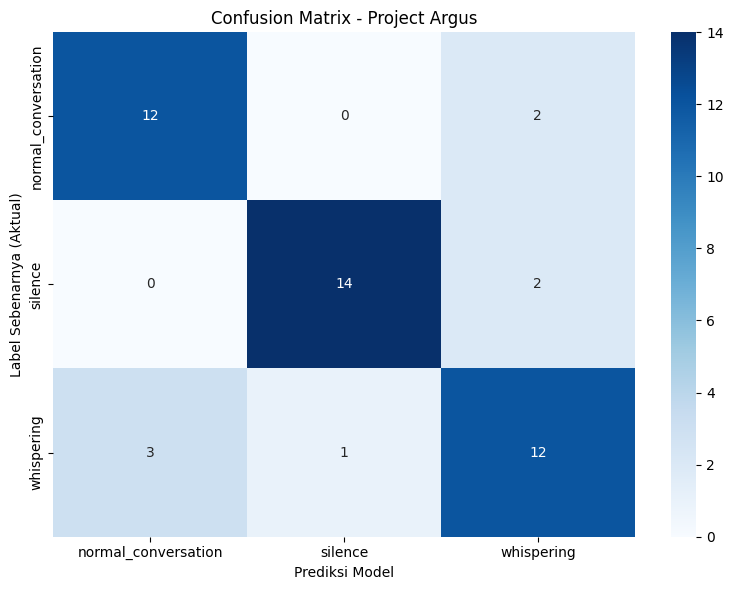

      Gambar tersimpan: hasil_confusion_matrix.png


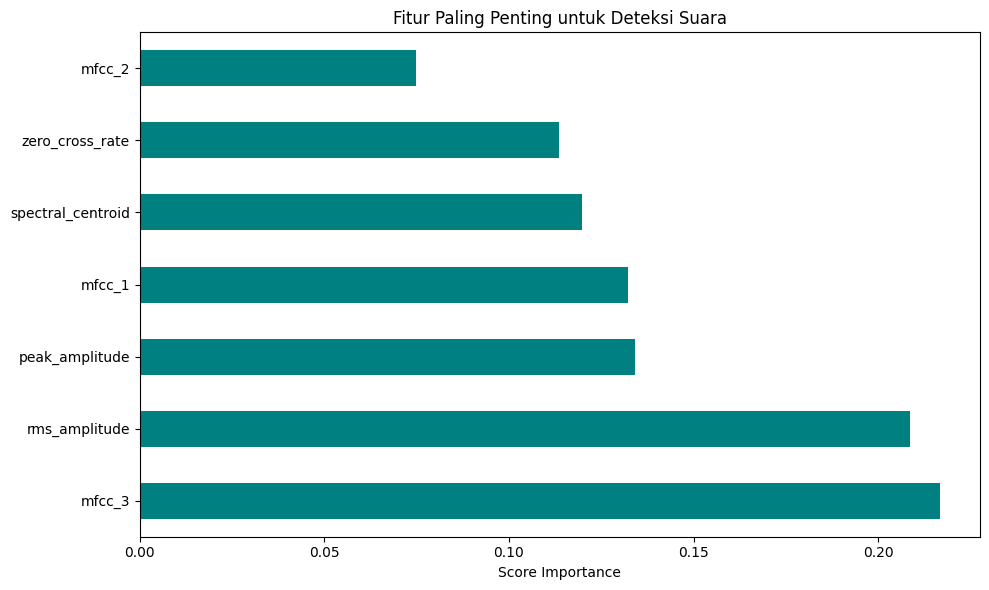

      Gambar tersimpan: hasil_feature_importance.png

[6/6] Menyimpan Model...
      Model disimpan ke: argus_audio_model.pkl
      Scaler disimpan ke: argus_scaler.pkl

=== PROSES SELESAI ===

--- Simulasi Prediksi Satu Data Baru ---
Input Fitur (Raw): [[ 1.29943180e-02  1.24204144e-01  2.88529830e-02  1.06360801e+03
  -4.82085660e+02  1.49737340e+02  1.92346360e+01]]
Prediksi AI: normal_conversation
Confidence: 65.00%


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ================= KONFIGURASI =================
DATASET_FILE = "argus_audio_dataset.csv"
MODEL_FILENAME = "argus_audio_model.pkl"
SCALER_FILENAME = "argus_scaler.pkl"
TEST_SIZE = 0.2  # 20% data untuk testing, 80% untuk training
RANDOM_STATE = 42 # Agar hasil konsisten
# ===============================================

def train_argus_model():
    print("=== MEMULAI TRAINING MODEL ARGUS ===")
    
    # 1. LOAD DATASET
    # -------------------------------------------
    try:
        df = pd.read_csv(DATASET_FILE)
        print(f"[1/6] Dataset dimuat: {len(df)} baris data.")
    except FileNotFoundError:
        print(f"Error: File {DATASET_FILE} tidak ditemukan!")
        return

    # Cek keseimbangan data (Penting untuk laporan)
    print("\nDistribusi Label Data:")
    print(df['label'].value_counts())

    # 2. PREPROCESSING
    # -------------------------------------------
    print("\n[2/6] Melakukan Preprocessing...")
    
    # A. Pisahkan Fitur (X) dan Target/Label (y)
    # Kita buang 'timestamp' karena tidak berguna untuk prediksi, hanya untuk urutan
    X = df.drop(['timestamp', 'label'], axis=1) 
    y = df['label']
    
    # B. Split Data (Training vs Testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    
    # C. Scaling (Standarisasi)
    # Penting agar fitur seperti 'spectral_centroid' (ribuan) tidak mendominasi 'rms' (desimal)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"      Data Training: {len(X_train)} sampel")
    print(f"      Data Testing:  {len(X_test)} sampel")

    # 3. MODEL TRAINING
    # -------------------------------------------
    print("\n[3/6] Melatih Model Random Forest...")
    
    # Menggunakan Random Forest karena tangguh untuk klasifikasi audio tabular
    model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X_train_scaled, y_train)
    
    print("      Training selesai.")

    # 4. EVALUASI MODEL (Wajib untuk Laporan SIC)
    # -------------------------------------------
    print("\n[4/6] Evaluasi Performa Model...")
    
    y_pred = model.predict(X_test_scaled)
    
    # Hitung Metrik
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n---> AKURASI MODEL: {acc*100:.2f}% <---")
    print("\nClassification Report (Precision, Recall, F1-Score):")
    print(report)

    # 5. VISUALISASI (Untuk Dokumentasi Laporan/Video)
    # -------------------------------------------
    print("[5/6] Membuat Visualisasi Hasil...")
    
    # A. Visualisasi Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Sebenarnya (Aktual)')
    plt.title('Confusion Matrix - Project Argus')
    plt.tight_layout()
    plt.savefig('hasil_confusion_matrix.png') # Simpan gambar
    plt.show()
    print("      Gambar tersimpan: hasil_confusion_matrix.png")
    
    # B. Visualisasi Feature Importance (Wawasan AI)
    # Ini bagus untuk menjelaskan ke juri: "Fitur apa yang paling membedakan bisikan?"
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    plt.figure(figsize=(10, 6))
    feature_importances.nlargest(10).plot(kind='barh', color='teal')
    plt.title('Fitur Paling Penting untuk Deteksi Suara')
    plt.xlabel('Score Importance')
    plt.tight_layout()
    plt.savefig('hasil_feature_importance.png')
    plt.show()
    print("      Gambar tersimpan: hasil_feature_importance.png")

    # 6. SIMPAN MODEL (DEPLOYMENT READY)
    # -------------------------------------------
    print("\n[6/6] Menyimpan Model...")
    
    # Kita simpan Model DAN Scaler. Scaler wajib disimpan agar data input nanti bisa diskalakan sama persis.
    with open(MODEL_FILENAME, 'wb') as f:
        pickle.dump(model, f)
        
    with open(SCALER_FILENAME, 'wb') as f:
        pickle.dump(scaler, f)
        
    print(f"      Model disimpan ke: {MODEL_FILENAME}")
    print(f"      Scaler disimpan ke: {SCALER_FILENAME}")
    print("\n=== PROSES SELESAI ===")

    # BONUS: TES PREDIKSI SINGLE DATA (Simulasi Real-time)
    print("\n--- Simulasi Prediksi Satu Data Baru ---")
    # Ambil contoh 1 data dari test set
    contoh_data = X_test.iloc[0].values.reshape(1, -1) 
    # Scale dulu (WAJIB)
    contoh_data_scaled = scaler.transform(contoh_data)
    # Prediksi
    hasil = model.predict(contoh_data_scaled)
    probabilitas = model.predict_proba(contoh_data_scaled)
    
    print(f"Input Fitur (Raw): {contoh_data}")
    print(f"Prediksi AI: {hasil[0]}")
    print(f"Confidence: {np.max(probabilitas)*100:.2f}%")

if __name__ == "__main__":
    train_argus_model()